# Spectra Multi-Gaussian/Lorentzian Fit

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, cauchy
from scipy.optimize import minimize
from astropy.io import fits

## Plotting all H$\alpha$ spectra

In [7]:
def plotSpectra(SN,halpha,trim=500,pltBound=6000,saveFig = False):
    fit = fits.open('SN_Images/%s/%s.ms.fits'%(SN,SN))
    
    w1 = fit[0].header['CRVAL1']
    dw = fit[0].header['CD1_1']
    
    data = fit[0].data[trim:-trim]
    w1 += dw*trim
    
    wspace = np.linspace(w1 - halpha, w1 + dw*len(data) - halpha, len(data))
    vspace = wspace*3e5/halpha
    
    plt.figure(figsize=(10,4))
    plt.plot(vspace,data/max(data))
    plt.xlim(-pltBound,pltBound)
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Intensity (Normalized)')
    plt.title(SN)
    plt.tight_layout()
    
    if saveFig:
        plt.savefig('SN_Images/%s/%s_Halpha.png'%(SN,SN))
    
    plt.show()
    
    return wspace, vspace, data

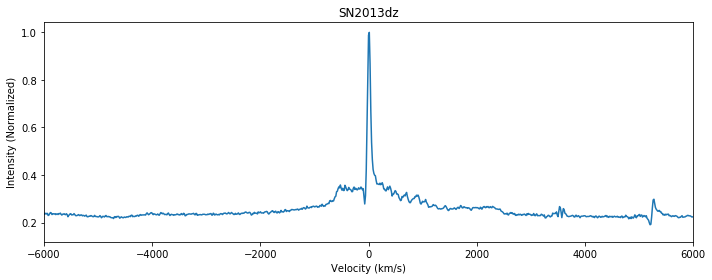

In [8]:
sn13dz = plotSpectra('SN2013dz', 6881.42, saveFig = True)

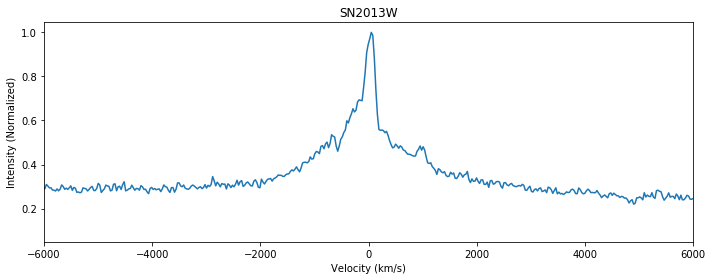

In [9]:
sn13W = plotSpectra('SN2013W', 6761.98, saveFig = True)

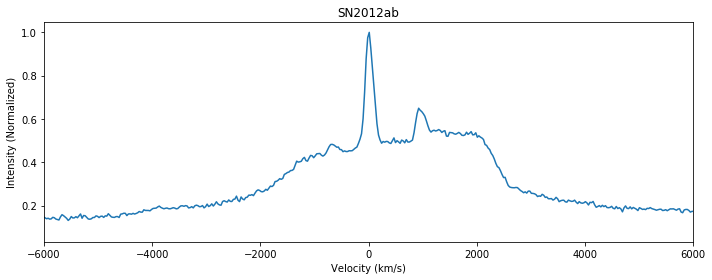

In [10]:
sn12ab = plotSpectra('SN2012ab', 6679.83, trim = 1600, saveFig = True)

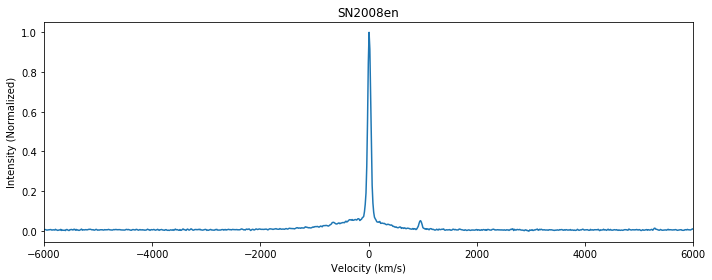

In [11]:
sn08en = plotSpectra('SN2008en', 6804.05, trim = 1600, saveFig = True)

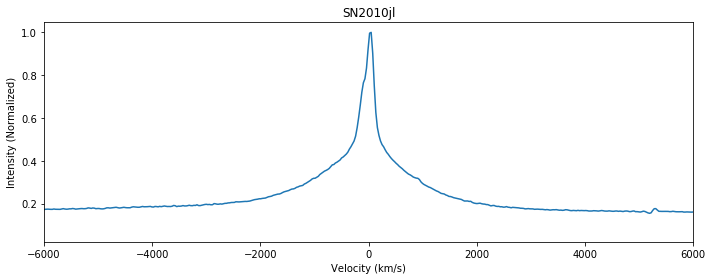

In [12]:
sn10jl = plotSpectra('SN2010jl', 6632.79, saveFig = True)

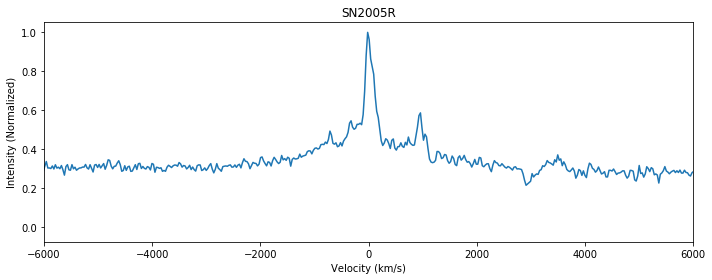

In [13]:
sn05R = plotSpectra('SN2005R', 6801.11, saveFig = True)

## Obtaining a Fit and plotting it

In [18]:
def gaussFit(ncomp,pGuess,x,y,lorentz=True):
    '''
    Create a fit using multiple gaussians/lorentzians.
    
    Parameters
    ----------
    ncomp  : number of gaussian/lorentzian components
    pGuess : an array of guesses in the order loc, scale, weight. shape is n_comp x 3
    x      : space in x over where to calculate the fits
    y      : the data being fit
    cauchy : if True, this will use Lorentzian profiles instead of Gaussian profiles
    '''
    try:
        pGuess = np.array(pGuess).reshape(ncomp*3,1)
    except ValueError:
        print("pGuess does not have the correct number of components!")
        return
    
    if lorentz:
        
        def loss(pGuess,x,y):
            yhat = 0
            for n in range(ncomp):
                yhat += pGuess[n*3+2]*cauchy.pdf(x,pGuess[n*3+0],pGuess[n*3+1])
            return ((y - yhat)**2).sum()
        
        res = minimize(loss,pGuess,args=(x,y),method='Nelder-Mead',options={'maxiter':1e6})
        fit = res['x'].reshape(ncomp,3)
        print(fit)
        print(res['message'],'\nn_iter:\t',res['nit'])
        fitData = 0
        for n in range(ncomp):
            fitData += fit[n][2]*cauchy.pdf(x,fit[n][0],fit[n][1])
        
        return {'fit':fit,'data':fitData}
    
    elif not lorentz:
        
        def loss(pGuess,x,y):
            yhat = 0
            for n in range(ncomp):
                yhat += pGuess[n*3+2]*norm.pdf(x,pGuess[n*3+0],pGuess[n*3+1])
            return ((y - yhat)**2).sum()
        
        res = minimize(loss,pGuess,args=(x,y),method='Nelder-Mead',options={'maxiter':1e6})
        fit = res['x'].reshape(ncomp,3)
        print(fit)
        print(res['message'],'\nn_iter:\t',res['nit'])
        fitData = 0
        for n in range(ncomp):
            fitData += fit[n][2]*norm.pdf(x,fit[n][0],fit[n][1])
        
        return {'fit':fit,'data':fitData}

In [37]:
def plotFit(ncomp,guess,data,vspace,lorentz=True):
    xspace = range(0,len(data))
    guess = np.array(guess).reshape(1,ncomp*3)
    fit = gaussFit(ncomp,guess,xspace,data,lorentz)
    plt.figure(figsize=(10,6))
    plt.xlim(vspace[0],vspace[-1])
    for n in range(ncomp):
        plt.plot(vspace,fit['fit'][n][2]*cauchy.pdf(xspace,fit['fit'][n][0],fit['fit'][n][1]),'--',alpha=0.5,
                 label='FWHM = %.2f km/s'%((vspace[1]-vspace[0])*fit['fit'][n][1]))
    plt.plot(vspace,fit['data'],'k')
    plt.fill_between(vspace,0,data,color='gray',alpha=0.5)
    plt.ylabel('Normalized Intensity',size=14)
    plt.xlabel('Velocity (km/s)',size=14)
    plt.legend()

In [38]:
def normSpec(data):
    return (data - min(data))/(max(data) - min(data))

### SN 2013dz

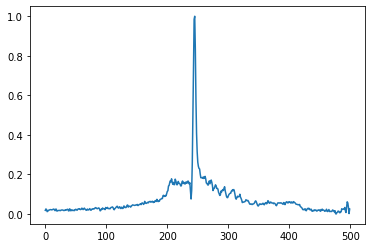

In [39]:
bounds = (5800,6300)
cut13dz_w = sn13dz[0][bounds[0]:bounds[1]]
cut13dz_v = sn13dz[1][bounds[0]:bounds[1]]
cut13dz_s = normSpec(sn13dz[2][bounds[0]:bounds[1]])
plt.plot(cut13dz_s)

[[244.69613231   1.94331694   5.71330483]
 [251.95462776  76.49566396  36.11297424]]
Optimization terminated successfully. 
n_iter:	 1461


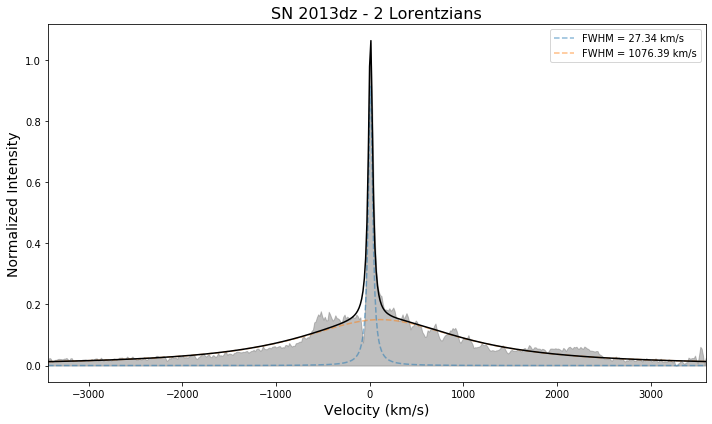

In [41]:
plotFit(2,[250,5,5]*2,cut13dz_s,cut13dz_v)
name = '2013dz'
plt.title('SN %s - 2 Lorentzians'%(name),size=16)
plt.tight_layout()
plt.savefig('SN_Images/SN%s/SN%s_fit.png'%(name,name))

### SN 2013W

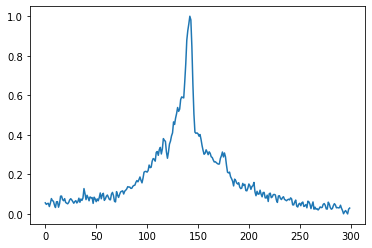

In [42]:
bounds = (3100,3400)
cut13W_w = sn13W[0][bounds[0]:bounds[1]]
cut13W_v = sn13W[1][bounds[0]:bounds[1]]
cut13W_s = normSpec(sn13W[2][bounds[0]:bounds[1]])
plt.plot(cut13W_s)

[[136.63381137  41.91155206  52.63282859]
 [141.07938584   3.53948219   6.97745742]]
Optimization terminated successfully. 
n_iter:	 908


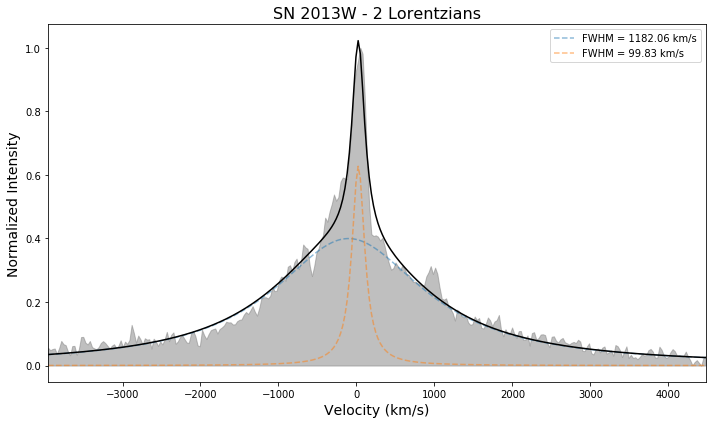

In [43]:
plotFit(2,[150,5,5]*2,cut13W_s,cut13W_v)
name = '2013W'
plt.title('SN %s - 2 Lorentzians'%(name),size=16)
plt.tight_layout()
plt.savefig('SN_Images/SN%s/SN%s_fit.png'%(name,name))

### SN 2012ab

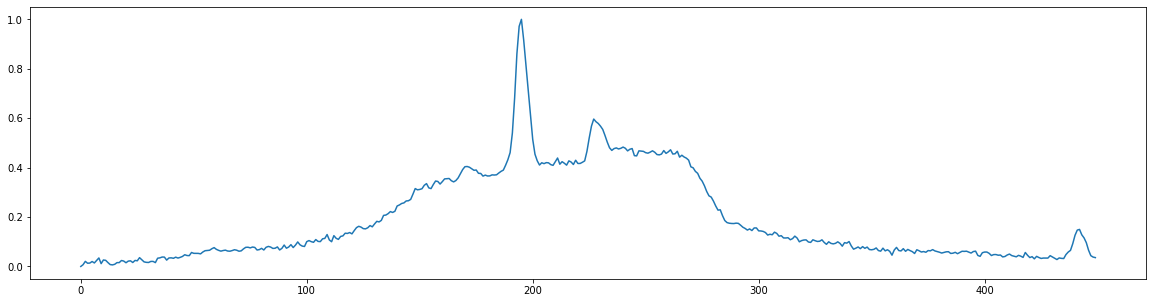

In [44]:
bounds = (1800,2250)
cut12ab_w = sn12ab[0][bounds[0]:bounds[1]]
cut12ab_v = sn12ab[1][bounds[0]:bounds[1]]
cut12ab_s = normSpec(sn12ab[2][bounds[0]:bounds[1]])
plt.figure(figsize=(20,5))
plt.plot(cut12ab_s)

[[ 1.94800002e+02  2.09418793e+00  4.07540375e+00]
 [ 2.20272305e+02  6.55659501e+01  1.04428206e+02]
 [-2.55324021e+03  1.23424296e+03 -7.99799322e+01]
 [ 2.02131681e+03  3.71284023e+02 -7.05550922e+00]]
Optimization terminated successfully. 
n_iter:	 3643


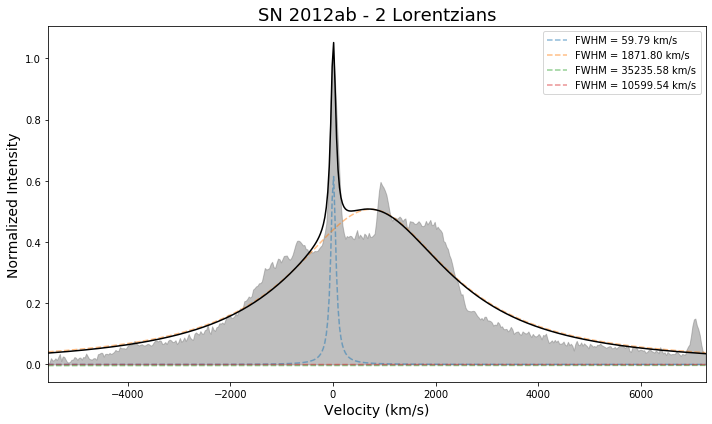

In [45]:
plotFit(4,[175,5,2,200,50,1,140,100,1,140,100,1],cut12ab_s,cut12ab_v)
name = '2012ab'
plt.title('SN %s - 2 Lorentzians'%(name),size=18)
plt.tight_layout()
plt.savefig('SN_Images/SN%s/SN%s_fit.png'%(name,name))

[[194.79804532   2.10416715   4.10037316]
 [220.44528093  64.68448969 102.42804582]]
Optimization terminated successfully. 
n_iter:	 223


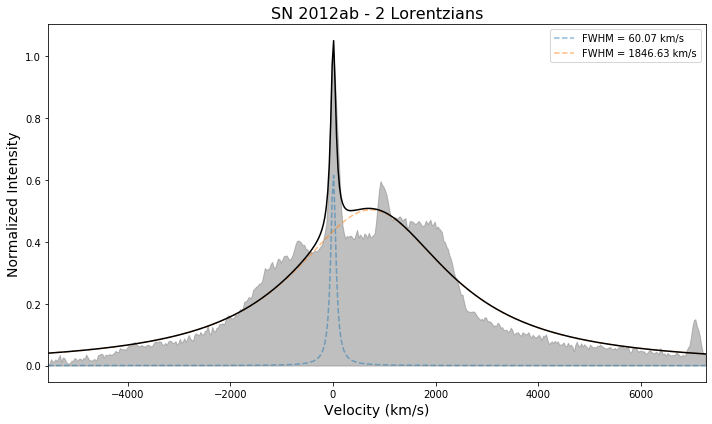

In [46]:
plotFit(2,[1.948e2,2.094,4.075,2.2027e2,6.55659e1,1.04428e2],cut12ab_s,cut12ab_v)
name = '2012ab'
plt.title('SN %s - 2 Lorentzians'%(name),size=16)
plt.tight_layout()
plt.savefig('SN_Images/SN%s/SN%s_fit.png'%(name,name))

### SN 2008en

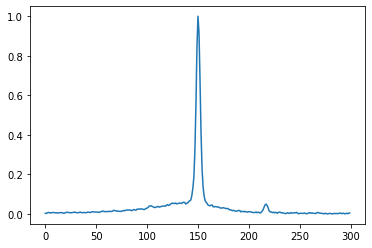

In [47]:
bounds = (4300,4600)
cut08en_w = sn08en[0][bounds[0]:bounds[1]]
cut08en_v = sn08en[1][bounds[0]:bounds[1]]
cut08en_s = normSpec(sn08en[2][bounds[0]:bounds[1]])
plt.plot(cut08en_s)

[[150.19392634   2.07579655   6.75270923]
 [117.92472166  40.02759494   4.48372397]]
Optimization terminated successfully. 
n_iter:	 736


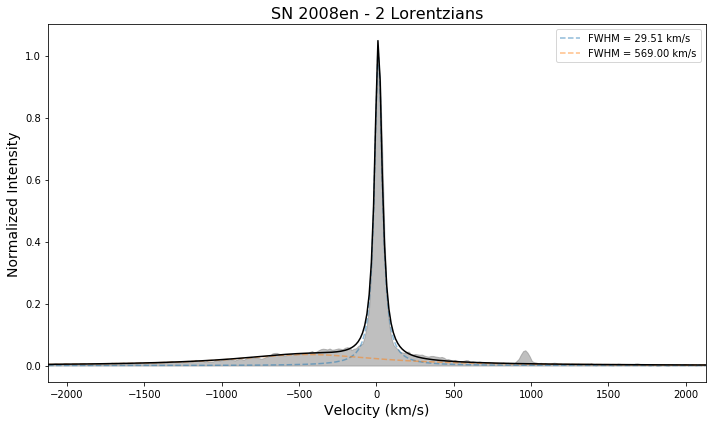

In [48]:
plotFit(2,[150,5,5,150,50,1],cut08en_s,cut08en_v)
name = '2008en'
plt.title('SN %s - 2 Lorentzians'%(name),size=16)
plt.tight_layout()
plt.savefig('SN_Images/SN%s/SN%s_fit.png'%(name,name))

### SN 2010jl

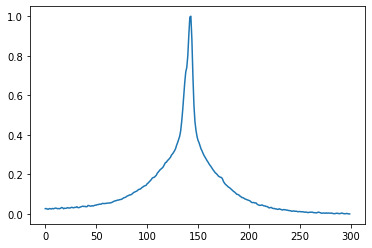

In [33]:
bounds = (2900,3200)
cut10jl_w = sn10jl[0][bounds[0]:bounds[1]]
cut10jl_v = sn10jl[1][bounds[0]:bounds[1]]
cut10jl_s = normSpec(sn10jl[2][bounds[0]:bounds[1]])
plt.plot(cut10jl_s)

[[137.18523834  33.12897232  33.64728462]
 [141.81712865   3.82575131   8.10277967]]
Optimization terminated successfully. 
n_iter:	 1358


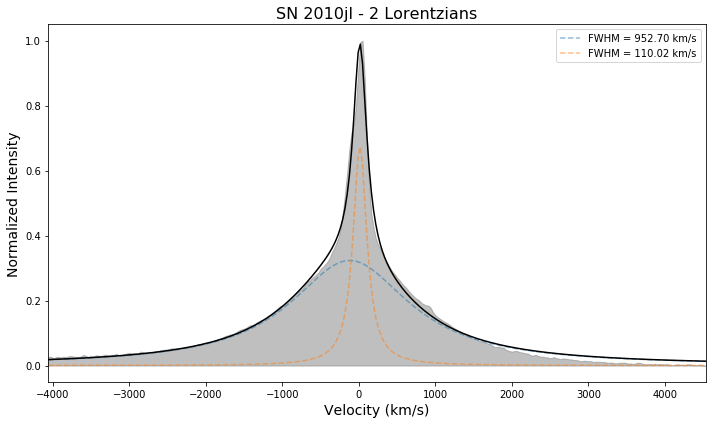

In [49]:
plotFit(2,[145,5,5,150,50,1],cut10jl_s,cut10jl_v)
name = '2010jl'
plt.title('SN %s - 2 Lorentzians'%(name),size=16)
plt.tight_layout()
plt.savefig('SN_Images/SN%s/SN%s_fit.png'%(name,name))

### SN 2005R

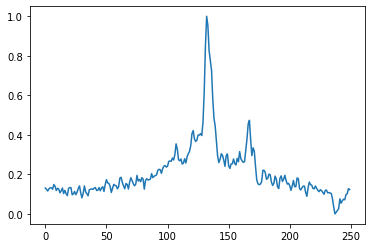

In [35]:
bounds = (2150,2400)
cut05R_w = sn05R[0][bounds[0]:bounds[1]]
cut05R_v = sn05R[1][bounds[0]:bounds[1]]
cut05R_s = normSpec(sn05R[2][bounds[0]:bounds[1]])
plt.plot(cut05R_s)

[[132.90671113   2.98971295   6.60777668]
 [131.99008897  76.41825188  68.84564117]]
Optimization terminated successfully. 
n_iter:	 1098


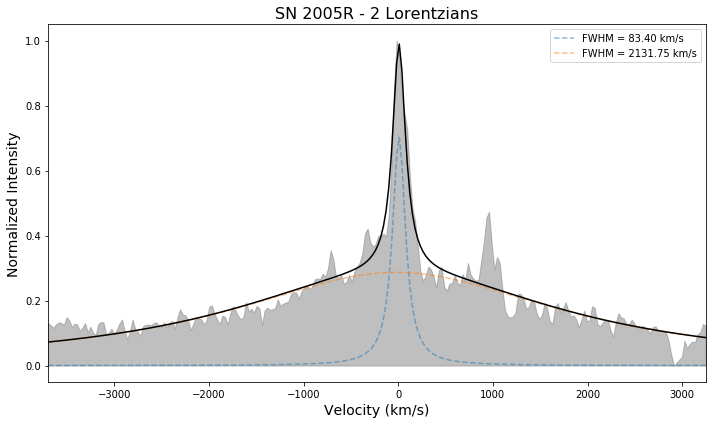

In [50]:
plotFit(2,[130,5,5,150,25,1],cut05R_s,cut05R_v)
name = '2005R'
plt.title('SN %s - 2 Lorentzians'%(name),size=16)
plt.tight_layout()
plt.savefig('SN_Images/SN%s/SN%s_fit.png'%(name,name))